In [1]:
# Props to this sensei
# https://www.youtube.com/watch?v=kCc8FmEb1nY&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=8

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # progress bar

device = ("cuda" if torch.cuda.is_available() else "mps"
          if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


## Hyper-parameters

In [3]:
batch_size = 64
text_file = "tiny-shakespeare.txt"



## Reading Data

In [4]:
# read file
with open(text_file, "r") as f:
    text = f.read()
text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [5]:
char_list = sorted(list(set(text)))
char_size = len(char_list)
print(f"All the characters in the text: {''.join(char_list)}")
print(f"Length of the characters: {char_size}")

All the characters in the text: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Length of the characters: 65


## Tokenizer (character based, index/ascii)

In [6]:
class MyTokenizer:
    def __init__(self):
        self.char_to_index = None
        self.index_to_char = None

    def fit(self, char_list):  
        self.char_to_index = {char: idx for idx, char in enumerate(char_list)}
        self.index_to_char = {idx: char for char, idx in self.char_to_index.items()}

    def encode_index(self, input_str):
        return [self.char_to_index[char] for char in input_str]

    def decode_index(self, encoded_list):
        return ''.join([self.index_to_char[idx] for idx in encoded_list])

    @staticmethod
    def ascii_tokenizer(char):
        return ord(char)

    @staticmethod
    def ascii_decoder(ascii_value):
        return chr(ascii_value)

    def encode_combined(self, input_str, use_ascii=False):
        if use_ascii:
            return [self.ascii_tokenizer(char) for char in input_str]
        else:
            return self.encode_index(input_str)

    def decode_combined(self, encoded_list, use_ascii=False):
        if use_ascii:
            return ''.join([self.ascii_decoder(ascii_value) for ascii_value in encoded_list])
        else:
            return self.decode_index(encoded_list)

In [7]:
# Example usage:
tokenizer = MyTokenizer()
tokenizer.fit(char_list)

input_str = "Hello there"
encoded_list_ascii = tokenizer.encode_combined(input_str, use_ascii=True)
decoded_str_ascii = tokenizer.decode_combined(encoded_list_ascii, use_ascii=True)

encoded_list_index = tokenizer.encode_combined(input_str, use_ascii=True)
decoded_str_index = tokenizer.decode_combined(encoded_list_index, use_ascii=True)

print("Original String:", input_str)
print("Encoded List (ASCII):", encoded_list_ascii)
print("Decoded String (ASCII):", decoded_str_ascii)

print("Encoded List (Index):", encoded_list_index)
print("Decoded String (Index):", decoded_str_index)

Original String: Hello there
Encoded List (ASCII): [72, 101, 108, 108, 111, 32, 116, 104, 101, 114, 101]
Decoded String (ASCII): Hello there
Encoded List (Index): [72, 101, 108, 108, 111, 32, 116, 104, 101, 114, 101]
Decoded String (Index): Hello there


In [8]:
# Encode all the data 
encoded_data = tokenizer.encode_combined(text) 
encoded_data[:10]

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47]

## Data Loader

In [9]:
data = torch.tensor(encoded_data)
data.shape[0]

1115393

In [10]:
class MyDataset(Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        return self.encoded_data[idx]
        
dataset = MyDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# printing the first batch
for batch in dataloader: 
    print(batch)
    break

tensor([61,  1, 28,  1, 21, 12, 24, 50,  1,  1,  1, 52, 44, 14,  1,  1, 58, 51,
        33,  1,  1,  1, 58, 39, 50, 52, 43, 58, 40,  0,  1, 27,  1, 58,  1, 58,
        43, 56, 56, 14, 46, 30,  6, 19, 43, 20, 42, 43,  6, 32,  0,  1, 10, 56,
        53, 42, 56, 47, 47, 63, 53, 47, 43, 63])


## GPT and language models
https://github.com/iVishalr/GPT/tree/main

In [11]:
# https://medium.com/@mingzehe/implement-transformer-via-pytorch-step-by-step-part-2-69f020d580c6

#attention 
def attention(k,q,v):
    # q dim [batch_size,n_heads,length,d_tensor]
    d_tensor = q.size(-1) 
    # assume dim of query/key/value vector should be same 
    # and it should be to make below calculation happen      
    k_t = k.transpose(-2,-1) #[batch_size,n_heads,d_tensor,length]
    score = (q @ k_t)/math.sqrt(d_tensor)
    v= torch.softmax(score,dim=-1) @ v
    return v,score

import copy
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
  # reduced dim for each Q,K,V, but added up to d_model
        self.d_k = d_model // n_head 
        self.n_head = n_head
        self.attn = None
  # use the attention class defined above
        self.attention = attention() 

  # 3 for K,Q,V, the forth layer is on the top for final attention score
        self.linears = clones(nn.Linear(d_model, d_model), 4) 

    def forward(self, q, k, v):
        samples = q.size(0) #q init as 512x512
    # split tensor by number of heads
        q, k, v = [   lin(x).view(samples, -1, self.n_head, self.d_k).transpose(1, 2)
    # [512,512] => [512,1,8,64] => [512,8,1,64] now we have 8 heads, 
    #length 1 since conv of size 1, dim of 64 for each q,k,v, 
    #ready for input to attention [batch_size, head, length, d_tensor]
            for lin, x in zip(self.linears, (q, k, v)) 
    # we only used 3 first linear layers since zip would 
        ]
        
    # calculate the attention score 
        x, self.attn = attention(q, k, v)

    # concat by view func [512, 8, 1, 64] => [512,1,512] add it back to 512
        x = (x.transpose(1, 2).contiguous().view(samples, -1, self.n_head * self.d_k))
    # now apply the final linear layer copy
        return self.linears[-1](x) 
   

class EncoderLayer(nn.Module):
    def __init__(self,n_head,d_model,hidden):
        super(Encoder_layer, self).__init__()
        self.norm = nn.LayerNorm(layer.size)
        self.attention_layer= MultiHeadAttention(d_model, n_head)
        self.feed_forward_layer= FeedForwardLayer(d_model, hidden)

    def forward(self, x):
        # we make a copy for later residue adding
        _x = x
        # use multi-head attention we defined in part 1
        atten = self.attention_layer(x)
        # add residue and normalize layer
        _atten = _x + self.norm(atten)
        # feed forward layer which we will define later 
        x = self.feed_forward_layer(x)
        return self.norm(x)+_atten

class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, hidden):
        super(FeedForwardLayer, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, hidden, n_head, n_copy):
        super().__init__()
        # n_copy = 6 
        self.layers = clones(EncoderLayer(d_model,hidden,n_head), n_copy)

    def forward(self, x):
        x = layer(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        # init as 515x512 matrix to make adding pos with input possible
        self.encoding = torch.zeros(max_len, d_model)
        # produce 0 to 511 pos index 
        pos = torch.arange(0, max_len)
        # convert to 512x1 size
        pos = pos.float().unsqueeze(dim=1)
        # pick 0,2,4...etc 256 even numbers, 
        # _2i refers to the index in above formula
        _2i = torch.arange(0, d_model, step=2).float()
        # pos index (512,1) divide by _2i (256)
        # broadcasting to (512,256), so every even column apply sin func
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        # odd column go through cos func
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        
    def forward(self, x):
        batch_size, seq_len = x.size() 
        #now to apply encoding
        return self.encoding[:seq_len, :]
        


In [12]:
class GPTModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_heads, num_layers):
        super(GPTModel, self).__init__()

        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Positional encoding
        self.positional_encoding = self.create_positional_encoding(embedding_dim)

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim)
            for _ in range(num_layers)
        ])

        # Fully connected layer for prediction
        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        # Token embedding
        embedded = self.embedding(x)

        # Add positional encoding
        positional_encoded = embedded + self.positional_encoding[:embedded.size(0), :]

        # Transformer layers
        transformer_output = positional_encoded
        for layer in self.transformer_layers:
            transformer_output = layer(transformer_output)

        # Fully connected layer for prediction
        output = self.fc(transformer_output)

        return output

    def create_positional_encoding(self, d_model, max_len=512):
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        positional_encoding = torch.zeros((max_len, d_model))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

# Example usage:
vocab_size = 10000  # replace with your vocabulary size
embedding_dim = 256
hidden_dim = 512
num_heads = 8
num_layers = 6

model = GPTModel(vocab_size, embedding_dim, hidden_dim, num_heads, num_layers)

# Print the model architecture
print(model)


GPTModel(
  (embedding): Embedding(10000, 256)
  (transformer_layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=256, out_features=10000, bias=True)
)


In [15]:

training_data = ["This is an example sentence.", "Another example here."]
training_data = text[:1000]

# Tokenize the dataset
# tokenized_data = encoded_data

tokenized_data = tokenizer.encode_combined(training_data) 

# Create an instance of the GPT model
model = GPTModel(vocab_size, embedding_dim, hidden_dim, num_heads, num_layers)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    for batch in dataloader:

        inpu
        # Forward pass
        output_logits = model(input_tensor)
    
        # Calculate loss
        loss = criterion(output_logits.view(-1, vocab_size), target_tensor)
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



ValueError: Expected input batch_size (64) to match target batch_size (999).

In [ ]:
# Inference after training
model.eval()
with torch.no_grad():
    # Generate text from a seed input
    seed_text = ''
    seed_tokenized = tokenizer.encode_combined(seed_text)
    input_tensor = torch.tensor(seed_tokenized).unsqueeze(0)
    generated_indices = torch.argmax(model(input_tensor), dim=-1).squeeze().tolist()
    generated_text = tokenizer.decode_combined(generated_indices) 

    print("Generated Text:", ''.join(generated_text))

In [ ]:
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(SimpleLanguageModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        # Embedding layer
        embedded = self.embedding(x)
        # LSTM layers
        output, hidden = self.lstm(embedded, hidden)
        # Output layer
        output = self.fc(output)
        return output, hidden

# Example usage:
# Set your vocabulary size, embedding dimension, hidden dimension, and number of LSTM layers
vocab_size = 100  # replace with the actual size of your vocabulary
embedding_dim = 64
hidden_dim = 128
num_layers = 2

# Create an instance of the SimpleLanguageModel
model = SimpleLanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers)

# Print the model architecture
print(model)


In [23]:
# https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal
0m 16s (5000 5%) 3.4128
0m 33s (10000 10%) 2.7357
0m 50s (15000 15%) 2.1298
1m 8s (20000 20%) 1.4868
1m 24s (25000 25%) 1.8462
1m 41s (30000 30%) 2.4166
1m 57s (35000 35%) 2.3470
2m 15s (40000 40%) 2.4300
2m 32s (45000 45%) 2.7701
2m 49s (50000 50%) 1.8545
3m 6s (55000 55%) 1.7337
3m 23s (60000 60%) 3.3119
3m 40s (65000 65%) 3.2292
3m 58s (70000 70%) 2.7137
4m 16s (75000 75%) 2.3650
4m 34s (80000 80%) 2.9670
4m 51s (85000 85%) 2.5167
5m 9s (90000 90%) 1.6618
5m 25s (95000 95%) 1.5570
5m 42s (100000 100%) 3.3716


Rovek
Uakov
Shakov
Gerter
Erengers
Roun
Sertana
Parez
Artana
Cha
Han
Iun


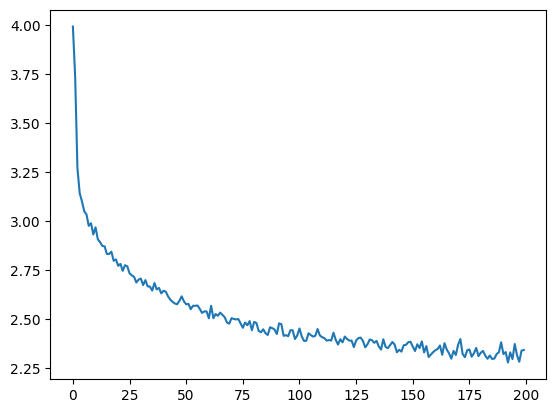

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')
